##Libraries

In [818]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

#Real Phones Random Forest

##Set up

In [816]:
use_grid_search = False

use_mean = True
use_median = False

use_feature_selection = False

In [817]:
# use_mean = False
# use_median = False
# choice = ''
# while choice not in ['1', '2', '3']:
#   print('1. Use mean')
#   print('2. Use median')
#   print('3. Use mode')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_mean = True
# elif choice == '2':
#   use_median = True

# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False

##Importing Cleaned Dataset

In [819]:
cleaned = pd.read_csv('Cleaned smartphones.csv')

cleaned.head()

,brand_name,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,472.314400,7.3,0,bionic,6.0,2.65,3110.000000,0,4,64,6.1,60,2,ios,12.0,12.0,0,1792,828
1,apple,569.201889,7.5,0,bionic,6.0,2.65,3110.000000,0,4,128,6.1,60,2,ios,12.0,12.0,0,1792,828
2,apple,629.756570,7.4,1,bionic,6.0,3.10,4817.748194,0,4,64,6.1,60,2,ios,12.0,12.0,0,2532,1170
3,apple,678.200315,7.5,1,bionic,6.0,3.10,4817.748194,0,4,128,6.1,60,2,ios,12.0,12.0,0,2532,1170
4,apple,823.531549,7.6,1,bionic,6.0,3.10,4817.748194,0,4,256,6.1,60,2,ios,12.0,12.0,0,2532,1170


##Preparing data for modelling

###Encoding Strings

In [820]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

cleaned.head()

brand_name
processor_brand
os


,brand_name,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,472.314400,7.3,0,bionic,6.0,2.65,3110.000000,0,4,64,6.1,60,2,ios,12.0,12.0,0,1792,828
1,apple,569.201889,7.5,0,bionic,6.0,2.65,3110.000000,0,4,128,6.1,60,2,ios,12.0,12.0,0,1792,828
2,apple,629.756570,7.4,1,bionic,6.0,3.10,4817.748194,0,4,64,6.1,60,2,ios,12.0,12.0,0,2532,1170
3,apple,678.200315,7.5,1,bionic,6.0,3.10,4817.748194,0,4,128,6.1,60,2,ios,12.0,12.0,0,2532,1170
4,apple,823.531549,7.6,1,bionic,6.0,3.10,4817.748194,0,4,256,6.1,60,2,ios,12.0,12.0,0,2532,1170


In [821]:
encoders = {}
for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", smooth = 5)
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    cleaned[col] = encoder.transform(X)
    encoders[col] = encoder

In [822]:
cleaned.columns

Index(['brand_name', 'price', 'avg_rating', '5G_or_not', 'processor_brand',
       'num_cores', 'processor_speed', 'battery_capacity',
       'fast_charging_available', 'ram_capacity', 'internal_memory',
       'screen_size', 'refresh_rate', 'num_rear_cameras', 'os',
       'primary_camera_rear', 'primary_camera_front',
       'extended_memory_available', 'resolution_height', 'resolution_width'],
      dtype='object')

In [823]:
cleaned.isnull().sum()

,0
brand_name,0
price,0
avg_rating,0
5G_or_not,0
processor_brand,0
num_cores,0
processor_speed,0
battery_capacity,0
fast_charging_available,0
ram_capacity,0


##Building Model

###Loading X and y

In [824]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [825]:
print(X.shape)
print(y.shape)

(873, 19)
(873,)


###Feature Selection

In [826]:
sfm = SelectFromModel(RandomForestRegressor(), threshold="median")
sfm.fit(X, y)

X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [827]:
importances = sfm.estimator_.feature_importances_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
      'Importance': importances
}).sort_values(by='Importance', ascending = False),

print(feature_scores)

# Get the indices of the selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

print("Selected Features:", selected_feature_names)

(                      Feature  Importance
5             processor_speed    0.556602
1                  avg_rating    0.094957
8                ram_capacity    0.068578
0                  brand_name    0.048706
15       primary_camera_front    0.042541
17          resolution_height    0.039405
6            battery_capacity    0.028278
9             internal_memory    0.021655
10                screen_size    0.019608
14        primary_camera_rear    0.015880
3             processor_brand    0.015273
2                   5G_or_not    0.014329
18           resolution_width    0.008940
16  extended_memory_available    0.008342
11               refresh_rate    0.005543
12           num_rear_cameras    0.004991
13                         os    0.004817
7     fast_charging_available    0.001284
4                   num_cores    0.000271,)
Selected Features: Index(['brand_name', 'avg_rating', 'processor_speed', 'battery_capacity',
       'ram_capacity', 'internal_memory', 'screen_size', 'primar

In [828]:
if use_feature_selection:
  X = X_new

###Splitting up training and testing data

In [829]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [830]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(698, 19)
(175, 19)
(698,)
(175,)


###Scaling Input Data

In [831]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Finding best parameters

In [832]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [833]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3)


In [834]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [835]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [836]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else: #use best paramaters found via grid search
  model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150,)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      max_leaf_nodes=200, n_estimators=150)

##Testing Model

In [837]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.993
Test Accuracy:  0.857


In [838]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# y_pred = price_scaler.inverse_transform(y_pred.reshape(-1,1))
# y_test = price_scaler.inverse_transform(y_test.values.reshape(-1,1))

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 39.16
Mean Absolute Percentage Error: 0.15


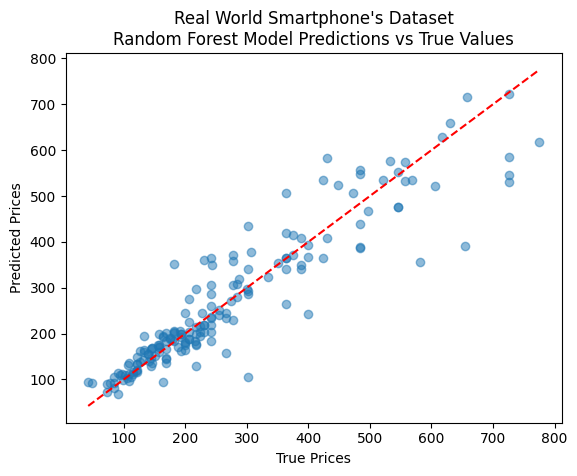

In [839]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Real World Smartphone's Dataset\nRandom Forest Model Predictions vs True Values")
plt.show()